In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
from scipy.stats import skew, norm, probplot, boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import lightgbm as lgb
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

import math
import copy
import shap

import sys
import os


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from setup import ROOT_DIR, CONFIG

figure_path = os.path.join(ROOT_DIR,"reports/figures")

In [59]:
def save_figure_to_report(directory, filename):
    if not os.path.exists(os.path.join(figure_path, directory)):
        os.makedirs(os.path.join(figure_path, directory))
    plt.savefig(os.path.join(figure_path, directory, filename))

### 1. Load the dataset

In [60]:
df_extended = pd.read_csv(os.path.join(ROOT_DIR,CONFIG["dataset_filepath"]))
df_extended.drop(['company_id'], axis=1, inplace=True)
df_extended.rename({'median_contribution':'contribution'},axis=1,inplace=True)
df_extended.rename({'median_age':'employee_age'},axis=1,inplace=True)
df_extended.rename({'median_pensionable_salary':'pensionable_salary'},axis=1,inplace=True)
df_extended.head()

,company_size_band,reg_address_district,reg_address_region,sic2007_category,legal_structure,state,company_age,regaddress_posttown,freq_period_type,company_percentage,employee_percentage,contribution,employee_age,pensionable_salary
0,1) 1 - 5 employees,Portsmouth,South East,Wholesale and retail trade; repair of motor ve...,Sole Trader,ceased_trading,0.0,CARSHALTON,Weekly,1.0,1.0,2160.0,39.0,191620.0
1,1) 1 - 5 employees,NaN,NaN,Construction,Sole Trader,closed,0.0,PURLEY,Monthly,1.0,1.0,2380.0,46.0,119000.0
2,2) 6 - 10 employees,London,Greater London,NaN,Limited Company,active,0.0,SALE,Monthly,1.0,1.0,7052.0,34.0,271960.0
3,1) 1 - 5 employees,Kirkaldy,Scotland,NaN,Charity,active,NaN,NaN,Monthly,7.0,0.0,29167.0,59.0,416667.0
4,1) 1 - 5 employees,Taunton,South West,NaN,Sole Trader,active,0.0,IPSWICH,Monthly,2.0,3.0,5878.0,46.0,125200.0


In [61]:
df_extended.columns

Index(['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure', 'state', 'company_age',
       'regaddress_posttown', 'freq_period_type', 'company_percentage',
       'employee_percentage', 'contribution', 'employee_age',
       'pensionable_salary'],
      dtype='object')

Let's take a look at the overview of the data

### 2. Overview

In [62]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: x.unique())
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration(%)', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration(%)', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

details = rstr(df_extended, 'contribution')
display(details.sort_values(by='corr contribution', ascending=False))

Data shape: (87776, 14)
___________________________
Data types:
 object     8
float64    6
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration(%),uniques,skewness,kurtosis,corr contribution
contribution,float64,87776,43001,0,0.000000,"[2160.0, 2380.0, 7052.0, 29167.0, 5878.0, 1520...",44.004840,3428.488073,1.000000
pensionable_salary,float64,87776,62081,0,0.000000,"[191620.0, 119000.0, 271960.0, 416667.0, 12520...",34.726636,2087.463409,0.874988
company_age,float64,86625,130,1151,1.311292,"[0.0, nan, 3.0, 2.0, 5.0, 12.0, 19.0, 13.0, 4....",3.589540,22.577305,0.091551
company_percentage,float64,87776,181,0,0.000000,"[1.0, 7.0, 2.0, 3.0, 2.5, 8.0, 5.0, 1.5, 4.0, ...",26.695177,1071.828213,0.074616
employee_percentage,float64,87776,160,0,0.000000,"[1.0, 0.0, 3.0, 5.0, 4.0, 2.0, 3.5, 4.75, 1.4,...",11.487111,480.449557,0.041281
employee_age,float64,87776,207,0,0.000000,"[39.0, 46.0, 34.0, 59.0, 48.0, 62.0, 33.0, 23....",0.348862,-0.526438,-0.010183
company_size_band,object,87776,9,0,0.000000,"[1) 1 - 5 employees, 2) 6 - 10 employees, Zero...",NaN,NaN,NaN
reg_address_district,object,81928,118,5848,6.662413,"[Portsmouth, nan, London, Kirkaldy, Taunton, T...",NaN,NaN,NaN
reg_address_region,object,81928,15,5848,6.662413,"[South East, nan, Greater London, Scotland, So...",NaN,NaN,NaN
sic2007_category,object,77227,22,10549,12.018092,[Wholesale and retail trade; repair of motor v...,NaN,NaN,NaN


regaddress_posttown has high cardinality with too many missing values, let's drop it for now

In [63]:
del df_extended['regaddress_posttown']
df_extended.columns

Index(['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure', 'state', 'company_age',
       'freq_period_type', 'company_percentage', 'employee_percentage',
       'contribution', 'employee_age', 'pensionable_salary'],
      dtype='object')

In [64]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title('Distribution of {} ( mu = {:.2f} and sigma = {:.2f} )'.format(measure, mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title('Probability Plot of {} (skewness: {:.6f} and kurtosis: {:.6f} )'.format(measure, data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    save_figure_to_report("distribution","contribution_distribution_and_qq_plot_{}.jpg".format(measure))
    plt.show()
    


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


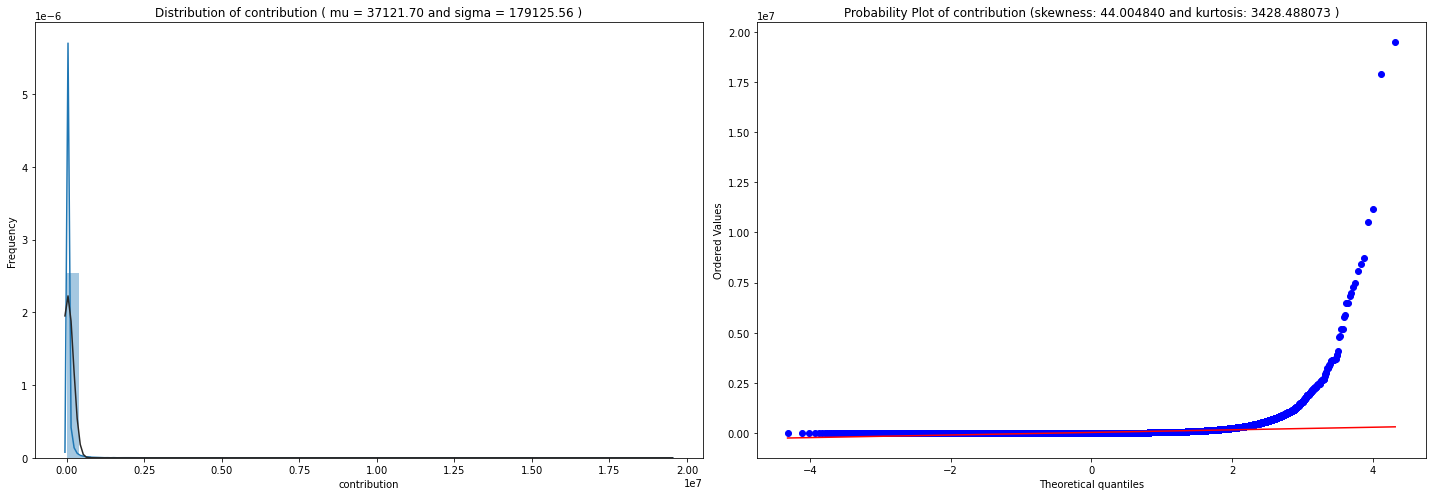

In [65]:
QQ_plot(df_extended['contribution'], 'contribution')

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


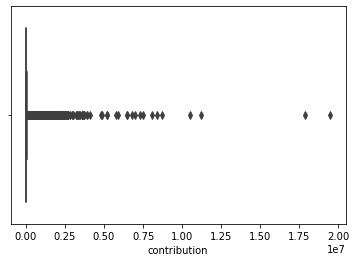

In [66]:
sns.boxplot(df_extended['contribution'])
plt.savefig(os.path.join(figure_path,"distribution", "boxplot_contribution_outlier.jpg"))

In [67]:
# long tail distribution, let's consider the value bigger than 1 * 1e7 as outliers
df_extended = df_extended.loc[df_extended['contribution'] < 1 * 1e7]

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


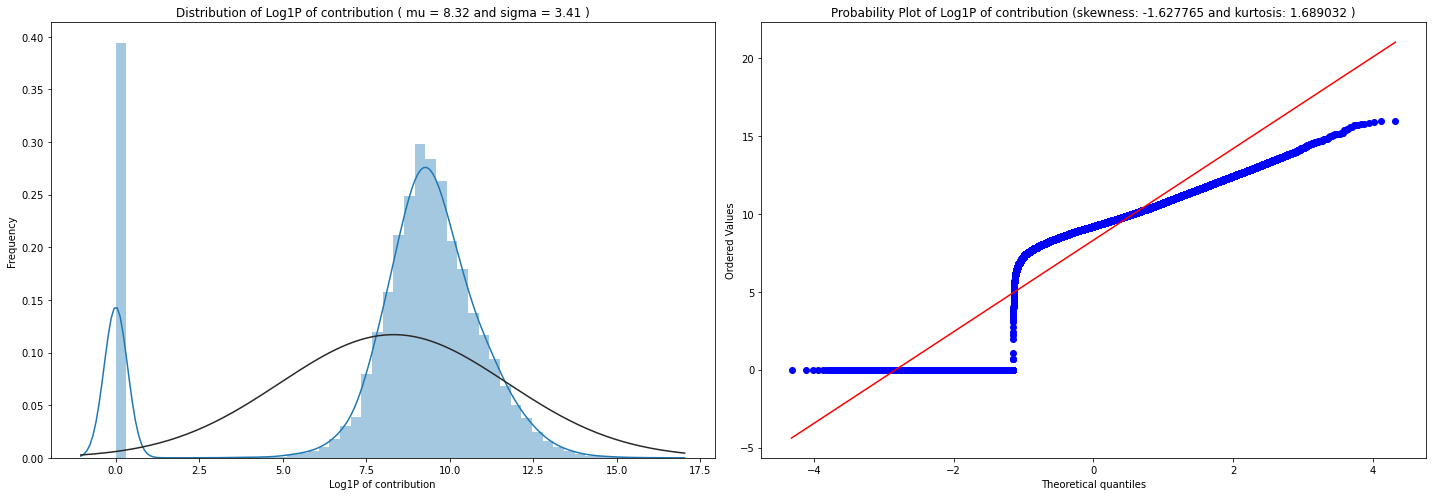

In [68]:
QQ_plot(np.log1p(df_extended['contribution']), 'Log1P of contribution')

In [69]:
# many 0 contributions in the dataset, let's take a closer look
df_extended.loc[df_extended['contribution'] <=0].describe(include='all').transpose()[['count','unique','top','freq','mean','std']]

,count,unique,top,freq,mean,std
company_size_band,11053,7,Zero employees,9321,NaN,NaN
reg_address_district,10468,115,London,2016,NaN,NaN
reg_address_region,10468,14,Greater London,3208,NaN,NaN
sic2007_category,9594,21,Wholesale and retail trade; repair of motor ve...,1485,NaN,NaN
legal_structure,11053,8,Limited Company,8962,NaN,NaN
state,11053,13,active,9084,NaN,NaN
company_age,10927,NaN,NaN,NaN,8.51066,9.27501
freq_period_type,11053,7,Monthly,8116,NaN,NaN
company_percentage,11053,NaN,NaN,NaN,1.98019,1.59152
employee_percentage,11053,NaN,NaN,NaN,2.85646,2.06296


In [70]:
# they are mostly for companies with zero employees, let's remove them
df_extended = df_extended.loc[df_extended['contribution']>0]

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


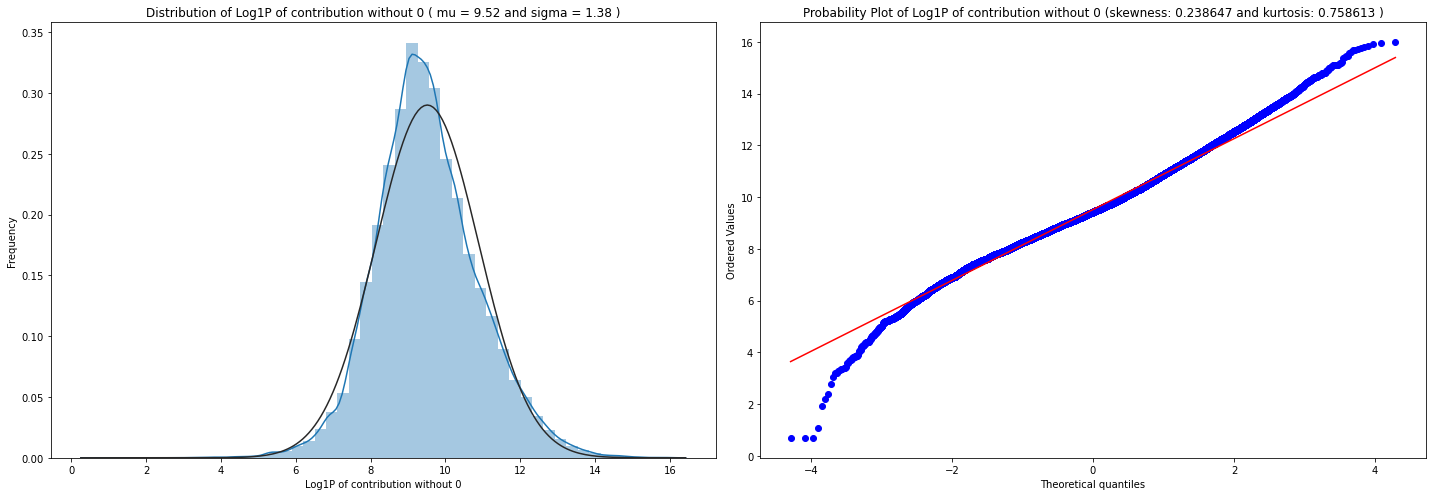

In [71]:
QQ_plot(np.log1p(df_extended.loc[df_extended['contribution']>0,'contribution']), 'Log1P of contribution without 0')

In [72]:
df_extended.columns

Index(['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure', 'state', 'company_age',
       'freq_period_type', 'company_percentage', 'employee_percentage',
       'contribution', 'employee_age', 'pensionable_salary'],
      dtype='object')

In [73]:
# let's take all the column as the features for the moment
df = df_extended[['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure', 'state', 'company_age',
       'freq_period_type', 'company_percentage', 'employee_percentage', 'contribution',
       'employee_age', 'pensionable_salary']]
df.head()

,company_size_band,reg_address_district,reg_address_region,sic2007_category,legal_structure,state,company_age,freq_period_type,company_percentage,employee_percentage,contribution,employee_age,pensionable_salary
0,1) 1 - 5 employees,Portsmouth,South East,Wholesale and retail trade; repair of motor ve...,Sole Trader,ceased_trading,0.0,Weekly,1.0,1.0,2160.0,39.0,191620.0
1,1) 1 - 5 employees,NaN,NaN,Construction,Sole Trader,closed,0.0,Monthly,1.0,1.0,2380.0,46.0,119000.0
2,2) 6 - 10 employees,London,Greater London,NaN,Limited Company,active,0.0,Monthly,1.0,1.0,7052.0,34.0,271960.0
3,1) 1 - 5 employees,Kirkaldy,Scotland,NaN,Charity,active,NaN,Monthly,7.0,0.0,29167.0,59.0,416667.0
4,1) 1 - 5 employees,Taunton,South West,NaN,Sole Trader,active,0.0,Monthly,2.0,3.0,5878.0,46.0,125200.0


In [74]:
# let's take a look at the data again after we clean some rows
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_size_band,76719,9,1) 1 - 5 employees,47412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_address_district,71456,117,London,11196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_address_region,71456,14,Greater London,17370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sic2007_category,67630,21,Administrative and support service activities,13370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
legal_structure,76719,8,Limited Company,65352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,76719,15,active,68546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_age,75694,NaN,NaN,NaN,8.74941,9.74382,0,2,6,11,144
freq_period_type,76719,7,Monthly,47470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_percentage,76719,NaN,NaN,NaN,2.70985,2.70199,0,2,3,3,200
employee_percentage,76719,NaN,NaN,NaN,3.93184,1.79198,0,3,5,5,100


In [75]:
# check the missing values
print("Missing values %")
(1 - df.count()/df.shape[0]) * 100

Missing values %


company_size_band        0.000000
reg_address_district     6.860100
reg_address_region       6.860100
sic2007_category        11.847130
legal_structure          0.000000
state                    0.000000
company_age              1.336045
freq_period_type         0.000000
company_percentage       0.000000
employee_percentage      0.000000
contribution             0.000000
employee_age             0.000000
pensionable_salary       0.000000
dtype: float64

In [76]:
# impute missing values 
for col in ['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure', 'state',
       'freq_period_type']:
    df.loc[df[col].isna(),col] = 'unknown'

for col in ['company_age']:
    df.loc[df[col].isna(),col] = df[col].median()

In [77]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_size_band,76719,9,1) 1 - 5 employees,47412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_address_district,76719,118,London,11196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reg_address_region,76719,15,Greater London,17370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sic2007_category,76719,22,Administrative and support service activities,13370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
legal_structure,76719,8,Limited Company,65352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,76719,15,active,68546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_age,76719,NaN,NaN,NaN,8.71268,9.68365,0,2,6,11,144
freq_period_type,76719,7,Monthly,47470,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_percentage,76719,NaN,NaN,NaN,2.70985,2.70199,0,2,3,3,200
employee_percentage,76719,NaN,NaN,NaN,3.93184,1.79198,0,3,5,5,100


In [78]:
def statistics(salary):
    mean = salary.mean()
    median = salary.median()
    mode = salary.mode()
    kurtosis = salary.kurtosis()
    skew = salary.skew()
    CV = variation(salary)
    
    stats = [
     ('Mean',round(mean,2)),
     ('Median',round(median,2)),
     ('Mode', int(mode)),
     ('Kurtosis',round(kurtosis,2)),
     ('Skew',round(skew,2)),
     ('Coefficient of variation',round(CV,2)) 
     ] 
    stats_df = pd.DataFrame.from_records(stats) 
    return stats_df
statistics(df['contribution']).set_index(0).transpose()

,Mean,Median,Mode,Kurtosis,Skew,Coefficient of variation
1,41702.07,12359.0,8000.0,837.27,22.66,3.74


### 3. Feature analysis

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


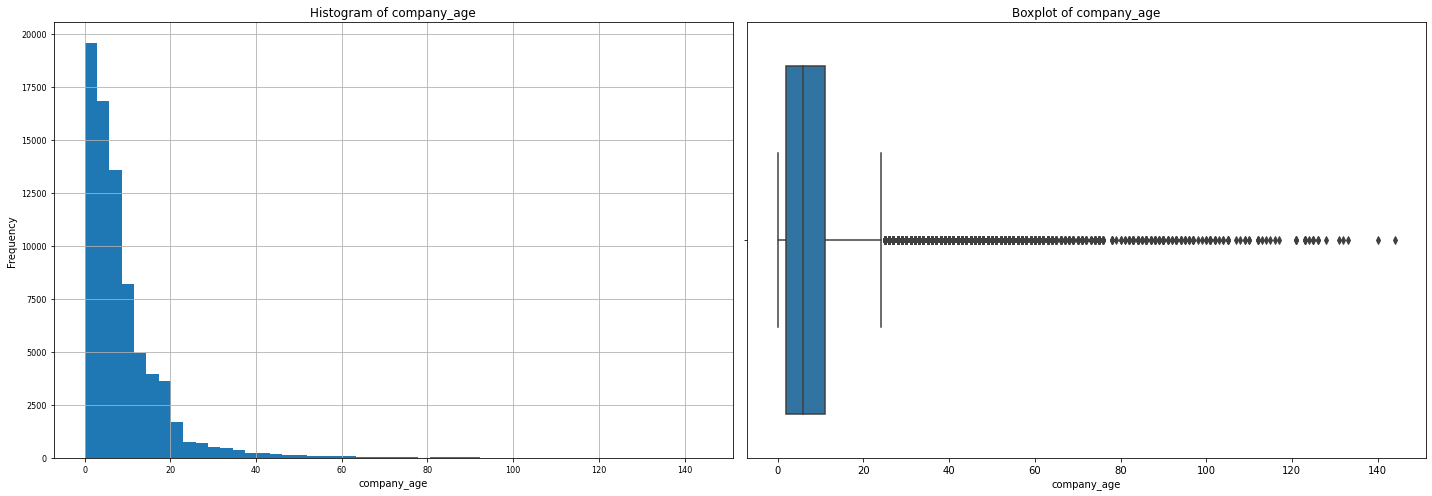

In [79]:
fig = plt.figure(figsize=(20,7))


#Kernel Density plot
fig1 = fig.add_subplot(121)
df['company_age'].hist(bins=50, xlabelsize=8, ylabelsize=8)
fig1.set_title("Histogram of company_age")
fig1.set_xlabel("company_age")
fig1.set_ylabel('Frequency')

#QQ plot
fig2 = fig.add_subplot(122)
sns.boxplot(df['company_age'])
# df['company_age'].hist(bins=50, xlabelsize=8, ylabelsize=8)
fig2.set_title("Boxplot of company_age")
fig2.set_xlabel("company_age")

# res = probplot(data, plot=fig2)

plt.tight_layout()
save_figure_to_report("features","company_age.jpg")

plt.show()

In [80]:
df['log_contribution'] = np.log(df['contribution'])

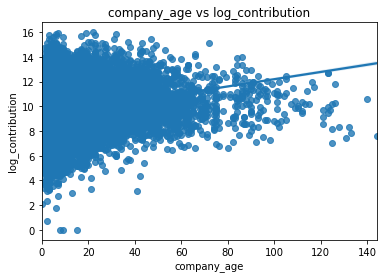

In [81]:
sns.regplot(x='company_age', y='log_contribution', data=df)
plt.title("company_age vs log_contribution")
save_figure_to_report("features","company_age_log_contribution.jpg")
plt.show()

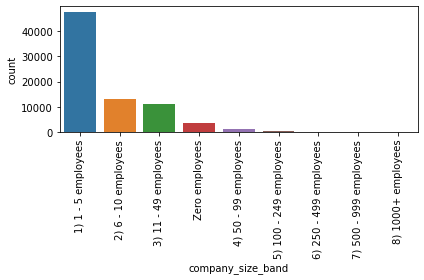

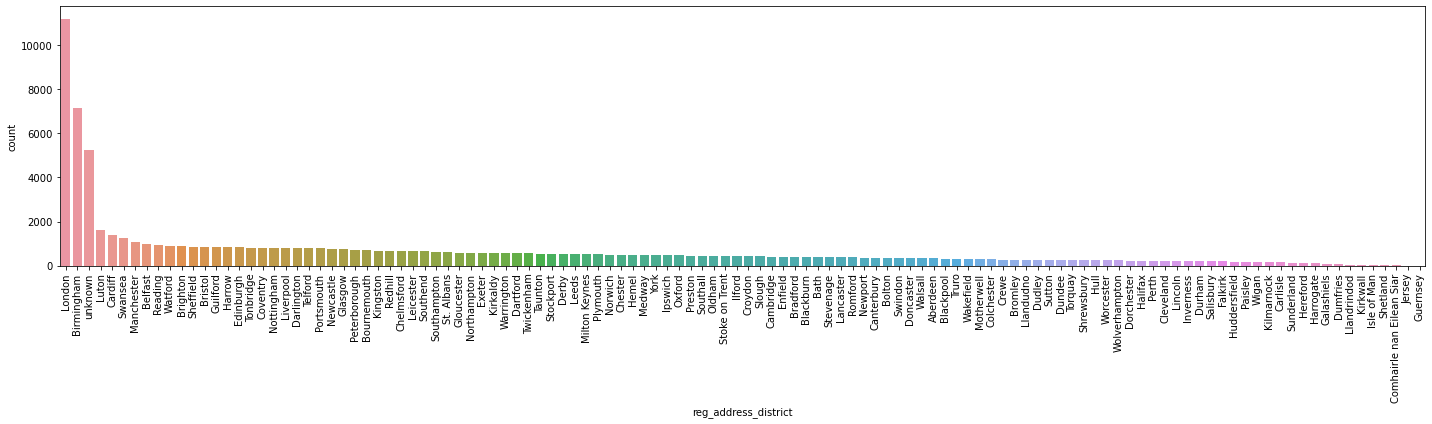

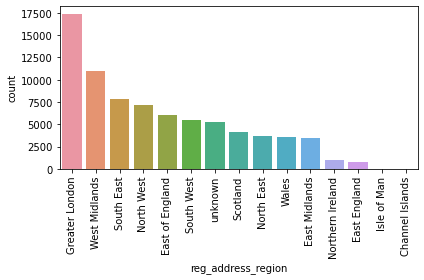

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


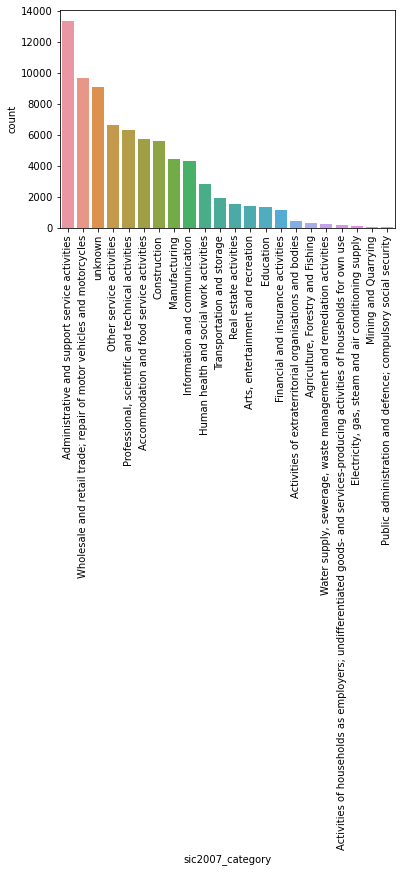

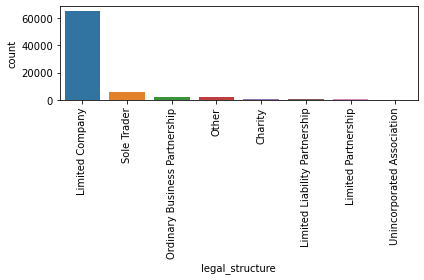

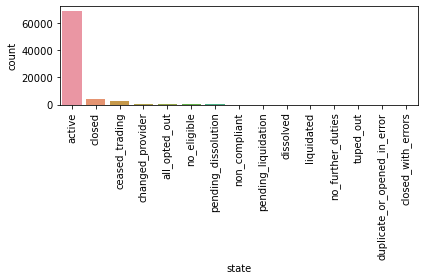

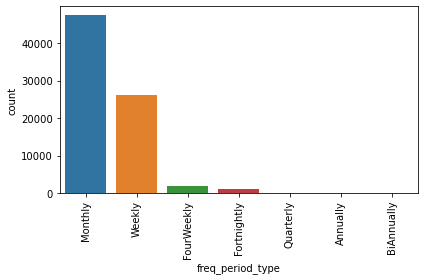

In [82]:
cate_features = ['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure','state',
       'freq_period_type']

order_dict = {
    'company_size_band': ['Zero employees',
                           '1) 1 - 5 employees', 
                          '2) 6 - 10 employees',
                          '3) 11 - 49 employees', 
                          '4) 50 - 99 employees',
                          '5) 100 - 249 employees',
                          '6) 250 - 499 employees',
                          '7) 500 - 999 employees', 
                          '8) 1000+ employees']
}

for col in cate_features:
    figsize =(14,6)
    if df[col].nunique() > 30:
        plt.figure(figsize=(20,6))
        
    ax = sns.countplot(x=df[col], data=df, order=df[col].value_counts().index)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=90)
    plt.tight_layout()
    save_figure_to_report("features","{}.jpg".format(col))
    plt.show()


In [83]:
# remove state column because it is dominated by 'active', probably also the legal structure, but let's try to keep it for the moment
del df['state']
df.columns

Index(['company_size_band', 'reg_address_district', 'reg_address_region',
       'sic2007_category', 'legal_structure', 'company_age',
       'freq_period_type', 'company_percentage', 'employee_percentage',
       'contribution', 'employee_age', 'pensionable_salary',
       'log_contribution'],
      dtype='object')

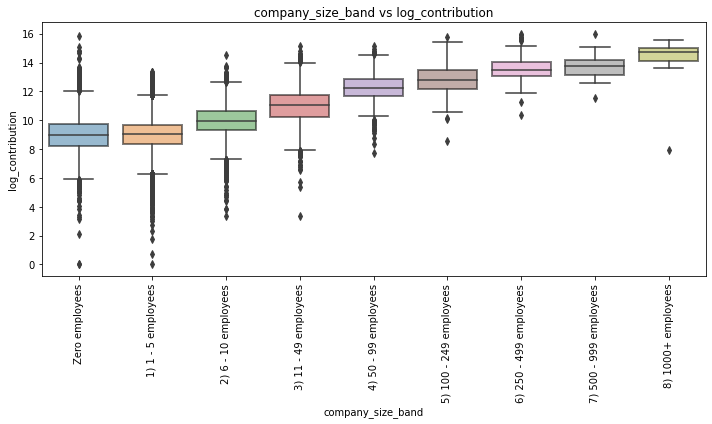

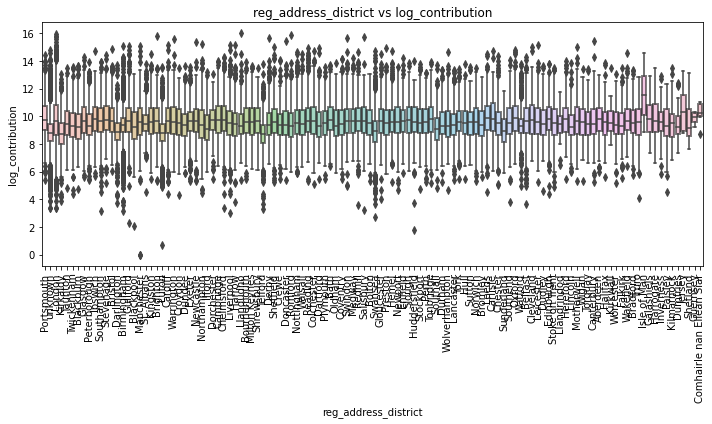

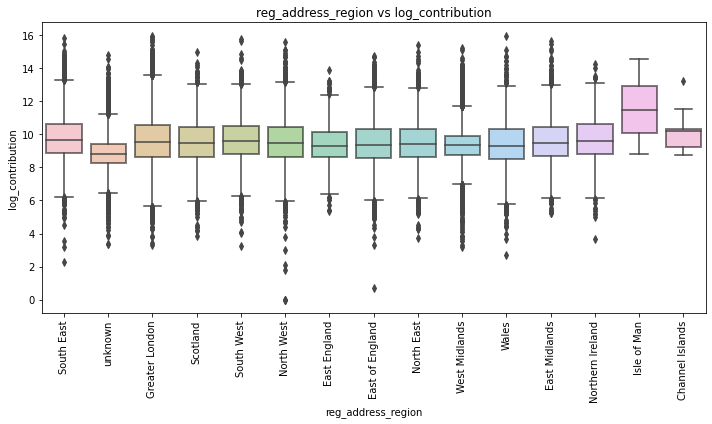

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


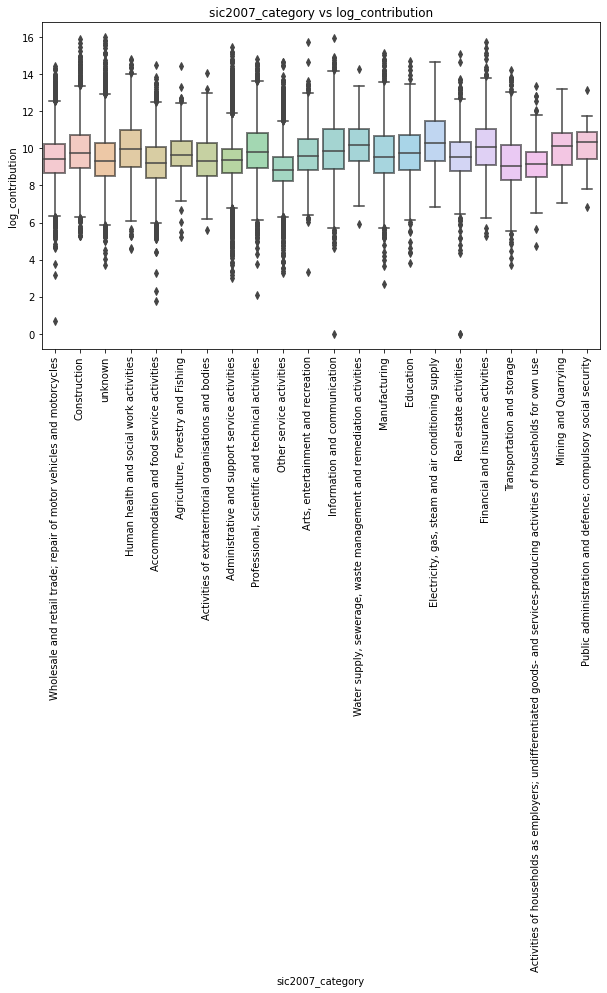

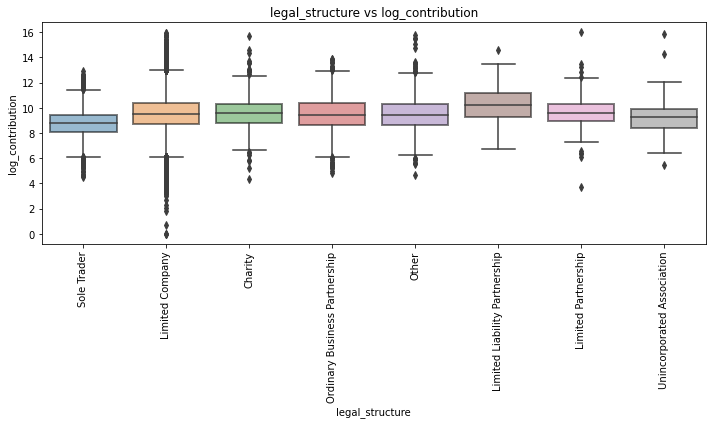

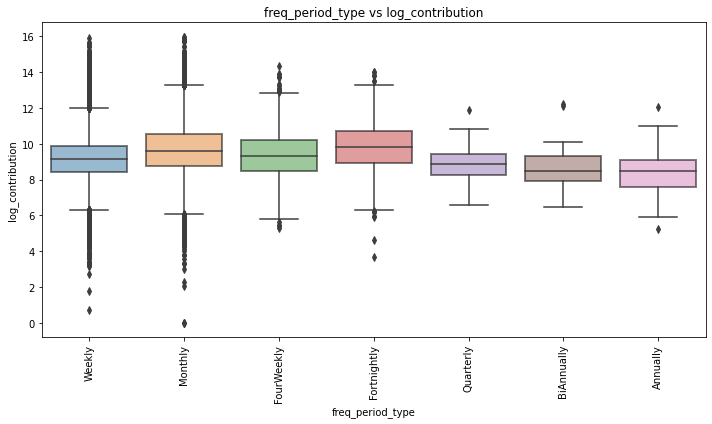

In [84]:
cate_features.remove('state')
for col in cate_features:
    plt.figure(figsize = (10, 6))
    order = None
    if col in order_dict:
        order = order_dict[col]
        
    ax = sns.boxplot(x=col, y='log_contribution', data=df, order=order)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=90)
    
    plt.title("{} vs log_contribution".format(col))
    plt.tight_layout()
    save_figure_to_report("features","boxplot_{}_contribution.jpg".format(col))
    plt.show()